In [1]:
import pandas as pd
import math
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import osmnx as ox
import sys, itertools
from collections import deque
from tqdm import tqdm
from utilities import *

In [2]:
# parameters
iteration = 200000   # number of iterations
temp = 5   # initial temperature

In [3]:
# read csv file
#file_path = './Trip_Matrix.csv'
#file_path = './data/Maven_stations_saved.csv'
file_path = './data/Dropoff_locations.csv'
df = pd.read_csv(file_path)
numberOfStops = len(df)
df

,Longitude,Latitude,Address
0,-79.389653,43.669624,Bay Station
1,-79.379568,43.768544,Bessarion Station
2,-79.368367,43.673658,Castle Frank Station
3,-79.418020,43.663659,Christie Station
4,-79.323692,43.683357,Coxwell Station
5,-79.346952,43.775110,Don Mills Station
6,-79.462910,43.750348,Downsview Station
7,-79.407034,43.674731,Dupont Station
8,-79.415660,43.780174,Finch Station
9,-79.437718,43.698421,Eglinton West Station


In [4]:
# store the values into a numpy array
Longitudes = df.iloc[:, 0].values
Latitudes  = df.iloc[:, 1].values
Addresses  = df.iloc[:, 2].values

In [5]:
POIS = []
for address in Addresses:
    POIS.append(poi(address,"canada"))
POIS

[Name: Bay ID: 25991314,
 Name: Bessarion ID: 5318484724,
 Name: Castle Frank Station ID: 432581398,
 Name: Christie ID: 5262888213,
 Name: Coxwell Station ID: 7100591226,
 Name: Don Mills Station ID: 1246332677,
 Name: Sheppard West ID: 420561530,
 Name: Dupont ID: 5320349317,
 Name: (Finch Station) ID: 582990836,
 Name: Eglinton West Station ID: 6592347255,
 Name: Kennedy Station ID: 5593394546,
 Name: Donlands ID: 55639063,
 Name: Kipling Station ID: 4597249809,
 Name: High Park Station ID: 2883464892,
 Name: Eglinton Station ID: 2266180445]

In [6]:
drawPOIS(POIS, zoom=10)

Map(center=[43.703626953333334, -79.39624480018968], close_popup_on_click=False, controls=(ZoomControl(options…

In [7]:
G = nx.DiGraph()
G.add_nodes_from(POIS)

In [8]:
# this will take 1-2 minutes because you need to find
# two routes between each pair of POIs
durations = []
for source in G.nodes():
    duration = []
    for destination in G.nodes():
        if source == destination: 
            duration.append(0)
            continue
        G.add_edge(source, destination, route = source.route_to(destination))
        route = source.route_to(destination)
        duration.append(route['duration'])
    durations.append(duration)

In [9]:
durations = np.array(durations)
durations

array([[   0. , 1243.5,  238.3,  306.9,  697.6, 1183.9, 1199.4,  239.3,
        1514.5,  730.3, 1347.5,  552.2, 1265.2,  765.1,  544.4],
       [1237.4,    0. ,  999.3, 1293.3, 1112.4,  281.2,  689.8, 1250. ,
         554.5,  747.6,  952.5, 1023.1, 1624. , 1310.6,  890.1],
       [ 238.1, 1095.6,    0. ,  501.8,  459.3,  945.6, 1355.9,  397.2,
        1522.1,  886.8, 1109.2,  313.9, 1323.7,  960. ,  656.6],
       [ 334.6, 1212.7,  529.7,    0. ,  989. , 1467.6, 1031.3,  225.6,
        1545.8,  562.2, 1638.9,  843.6, 1121.7,  497. ,  723. ],
       [ 697.4, 1076.9,  459.3,  961.1,    0. ,  926.9, 1575.4,  856.5,
        1503.4, 1223.3,  884.7,  170.8, 1524.8, 1275.2, 1049.5],
       [1264.2,  249.7, 1026.1, 1435.9, 1139.2,    0. ,  882.1, 1392.6,
         768. ,  890.2,  936. , 1049.9, 1766.6, 1453.2, 1032.7],
       [1211.8,  677. , 1370.8, 1063.1, 1617.1,  949.1,    0. , 1019.8,
         835.9,  517.4, 1457.2, 1527.8, 1468.5, 1137.5,  932.8],
       [ 224.2, 1164.9,  396.9,  240. ,  

In [10]:
# define a function that can compute the fitness value of the solution
def cal_fitness_1(m, sol):
    M = np.zeros(numberOfStops-1)
    for i in range(numberOfStops-1):
        M[i] = m[sol[i]-1,sol[i+1]-1]
    fitness = np.sum(M)
    return fitness

In [11]:
# create an array to store all individuals
sol_hist = np.zeros([iteration+1,numberOfStops])

# create an array to store all fitness values corresponding to the individual
fitness_hist = np.zeros(iteration+1)

# initialize the fitness array
for i in range(iteration+1):
    fitness_hist[i] = 99999

In [12]:
# generate the initial solution
initial_sol = np.arange(1,numberOfStops+1)
random.shuffle(initial_sol)
initial_sol = initial_sol.astype(int)

In [13]:
# compute the fitness of the initial solution
sol_hist[0] = initial_sol
fitness_hist[0] = cal_fitness_1(durations, initial_sol)

In [14]:
running_time = np.zeros(iteration)
best_outputs = []
# implementation of simulated annealing
# implementation of simulated annealing
for i in range(1,iteration+1):

    # record the starting time
    start_time = time.time()

    # generate new solution
    a = random.randint(0,numberOfStops-1)
    b = random.randint(0,numberOfStops-1)
    sol_hist[i] = sol_hist[i-1]
    sol_hist[i,a] = sol_hist[i-1,b]
    sol_hist[i,b] = sol_hist[i-1,a]
    sol = sol_hist[i]
    sol = sol.astype(int)

    # compute the fitness of the new solution
    fitness_hist[i] = cal_fitness_1(durations, sol)

    if fitness_hist[i] > fitness_hist[i-1]:
        prob = math.exp(-(abs(fitness_hist[i]-fitness_hist[i-1]))/temp)
        r = np.random.random()
        if r > prob:
            sol_hist[i] = sol_hist[i-1]

    # update the annealing temperature
    temp = temp*0.999

    # record the best output for every iteration
    best_outputs.append(np.min(fitness_hist))

    # compute and store the running time
    running_time[i-1] = time.time() - start_time


In [15]:
# return the index of the solution corresponding to the best fitness
best_index = np.where(fitness_hist == np.min(fitness_hist))

running_time = running_time.cumsum()

# to get the index of iteration when the fitness reaches its minimum value (convergence point of the algorithm)
convergence_index = np.where(best_outputs == np.min(best_outputs))
convergence_time = running_time[convergence_index]

print("The best solution is:", sol_hist[best_index].astype(int))
print('The best fitness value is:', fitness_hist[best_index])
print("The algorithm converges in", np.min(convergence_index), "iterations.")
print("The algorithm converges in", np.min(convergence_time), "seconds.")


The best solution is: [[15  1  5 12  3  8  4 14 13 10  7  2  6  9 11]]
The best fitness value is: [8226.9]
The algorithm converges in 42843 iterations.
The algorithm converges in 4.958059072494507 seconds.


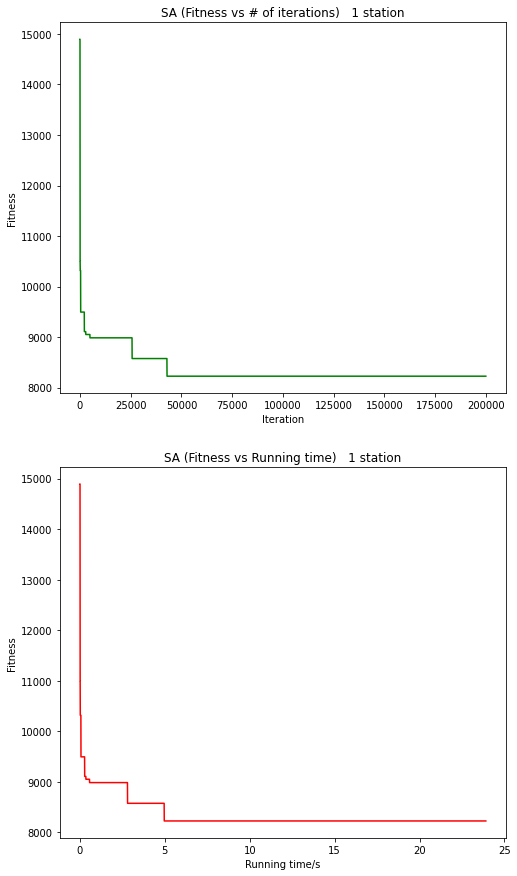

In [16]:
fig, ax = plt.subplots(2, figsize = (8,15))
ax[0].plot(best_outputs, 'green')
ax[0].set_xlabel("Iteration", fontsize = 10)
ax[0].set_ylabel("Fitness", fontsize = 10)
ax[0].set_title("SA (Fitness vs # of iterations)   1 station", fontsize = 12)

ax[1].plot(running_time, best_outputs, 'red')
ax[1].set_xlabel("Running time/s", fontsize = 10)
ax[1].set_ylabel("Fitness", fontsize = 10)
ax[1].set_title("SA (Fitness vs Running time)   1 station", fontsize = 12)
plt.show()

In [34]:
optimalRoute = sol_hist[best_index].astype(int)-1
optimalRoute = optimalRoute[0]
optimalRoute
currentRoute = G[POIS[optimalRoute[0]]][POIS[optimalRoute[1]]]['route']['coords']
for i in range(1,len(optimalRoute)-1):
    currentRoute += G[POIS[optimalRoute[i]]][POIS[optimalRoute[i+1]]]['route']['coords']
drawRoute(currentRoute)

Map(center=[43.773108, -79.283866], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…